# jammer
## 15 - Explore the new IGRINS data
### Part I. New data!

In [1]:
import pandas as pd

In [2]:
#! head -n 30 ../data/IGRINS/2M0136+0933_20161101_H_0030_merged.txt

In [3]:
dat = pd.read_csv('../data/IGRINS/2M0136+0933_20161101_H_0030_merged.txt', names=['wl', 'fl', 'sigma', 'msk'],
                  comment='#', delim_whitespace=True)

>The files have four columns each. The first is wavelength in microns. The second is flux, units are ergss-1cm-2A-1. The third and fourth columns I would ignore. The third one should be uncertainty but we aren't really sure we can trust those with the IGRINS data, and the fourth is a flag array that the SpeX data has but the IGRINS data doesn't, so its all zeroes. 

In [4]:
dat.head()

,wl,fl,sigma,msk
0,1.44088,-2086320.0,2223908.8,0.0
1,1.44090,-2811440.0,1738085.4,0.0
2,1.44091,26376000.0,8016290.5,0.0
3,1.44092,2313210.0,2858560.5,0.0
4,1.44093,-707306.0,1232425.1,0.0


## An example Marley model

In [5]:
mar = pd.read_csv('../../Starfish/libraries/raw/marley13/sp_t1300g1780nc_m0.0', 
                  names=['wavelength', 'flux'],
                  skiprows=3, 
                  delim_whitespace=True)

In [6]:
import astropy.units as u
import astropy.constants as C
c_val = C.c.to(u.cm/u.s).value
c_val

29979245800.0

In [7]:
x = mar.wavelength.values*u.micron
x_Hz = x.to(u.Hz, equivalencies=u.spectral())
x_Ang = x.to(u.Angstrom)


y0 = mar.flux.values*u.erg/u.cm**2/u.s/u.Hz
y = y0.to(u.erg/u.cm**2/u.s/u.Angstrom, 
          equivalencies=u.spectral_density(mar.wavelength.values*u.micron))

In [8]:
yl1, yl2 = np.nanpercentile(dat.fl, [10, 90])

(1.4, 1.85)

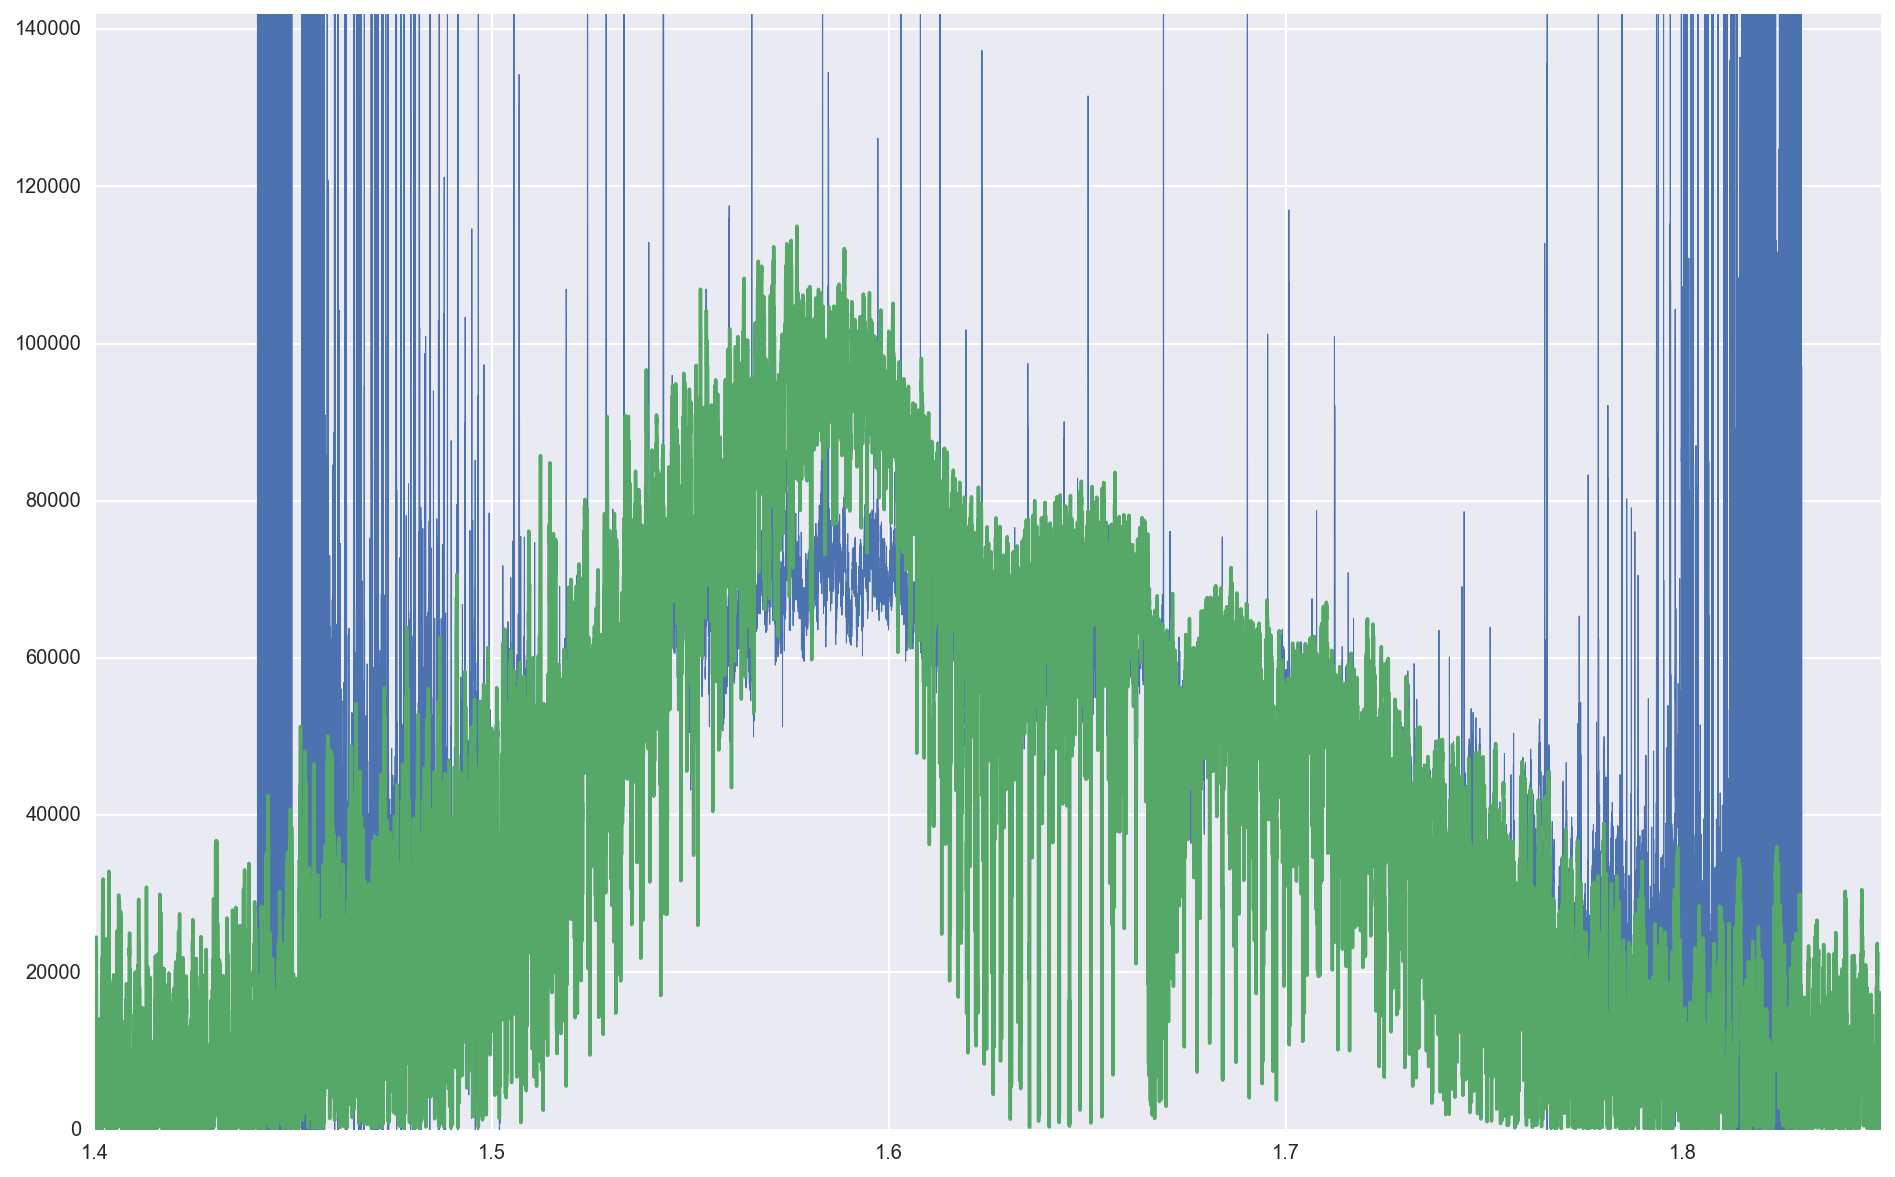

In [9]:
plt.figure(figsize=(16, 10))
plt.plot(dat.wl, dat.fl, lw=0.5)
plt.plot(x, y*6)
plt.ylim(0, 2.0*yl2)
plt.xlim(1.4, 1.85)

omg awesome, flux calibrated high resolution spectra, wtf!!

What's the $S/N$?

In [10]:
dat['sigma']=dat.sigma.astype(np.float)

In [11]:
len(dat)

36302

(-50, 100)

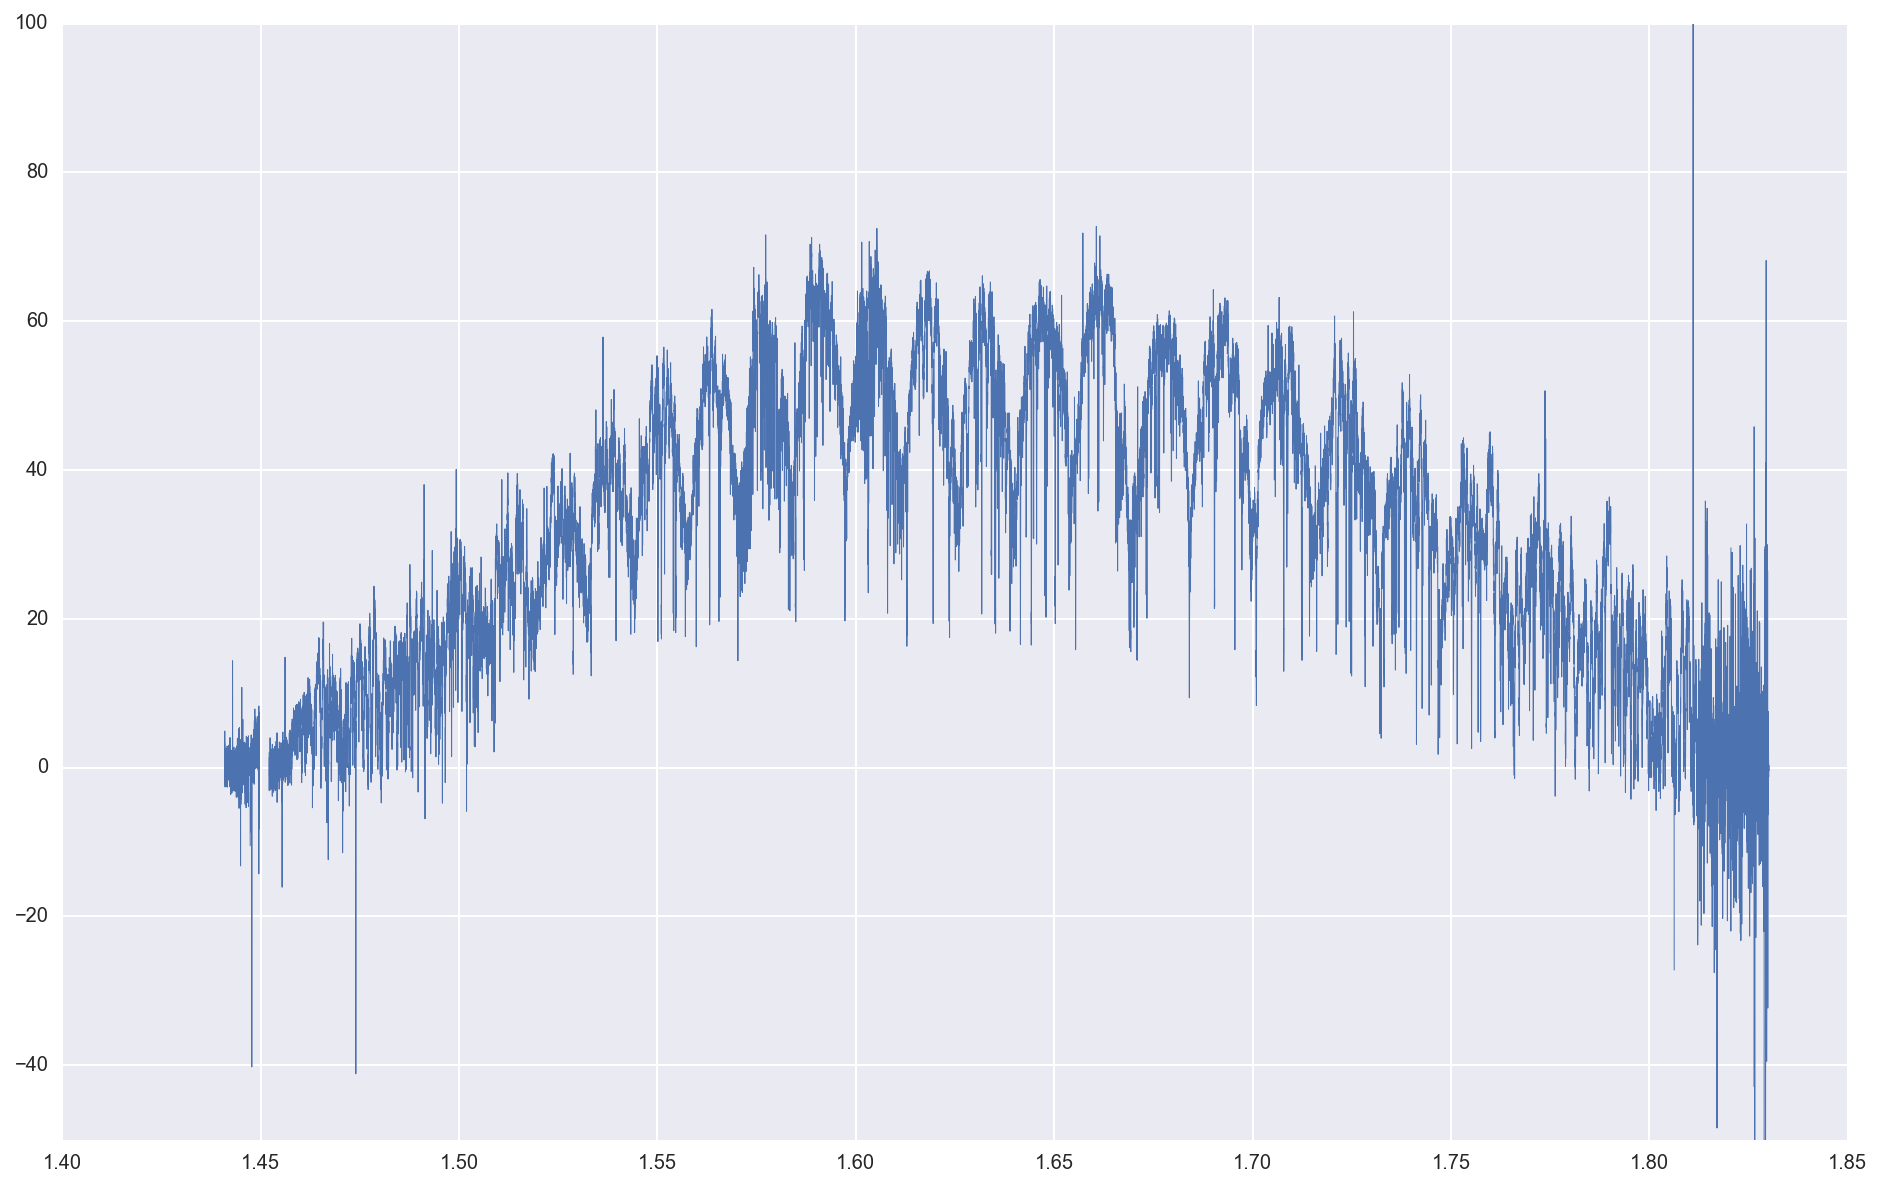

In [12]:
plt.figure(figsize=(16, 10))
plt.plot(dat.wl, dat.fl/dat.sigma, lw=0.5)
plt.ylim(-50, 100)

Wow, the $S/N$ looks like it's accurate!  Or at least sensible.  You can see the blaze shape :)

In [13]:
x1, x2 = 1.716, 1.731
x1, x2 = 1.655, 1.669
x1, x2 = 1.585, 1.595
x1, x2 = 1.519, 1.532

(1.4989999999999999, 1.552)

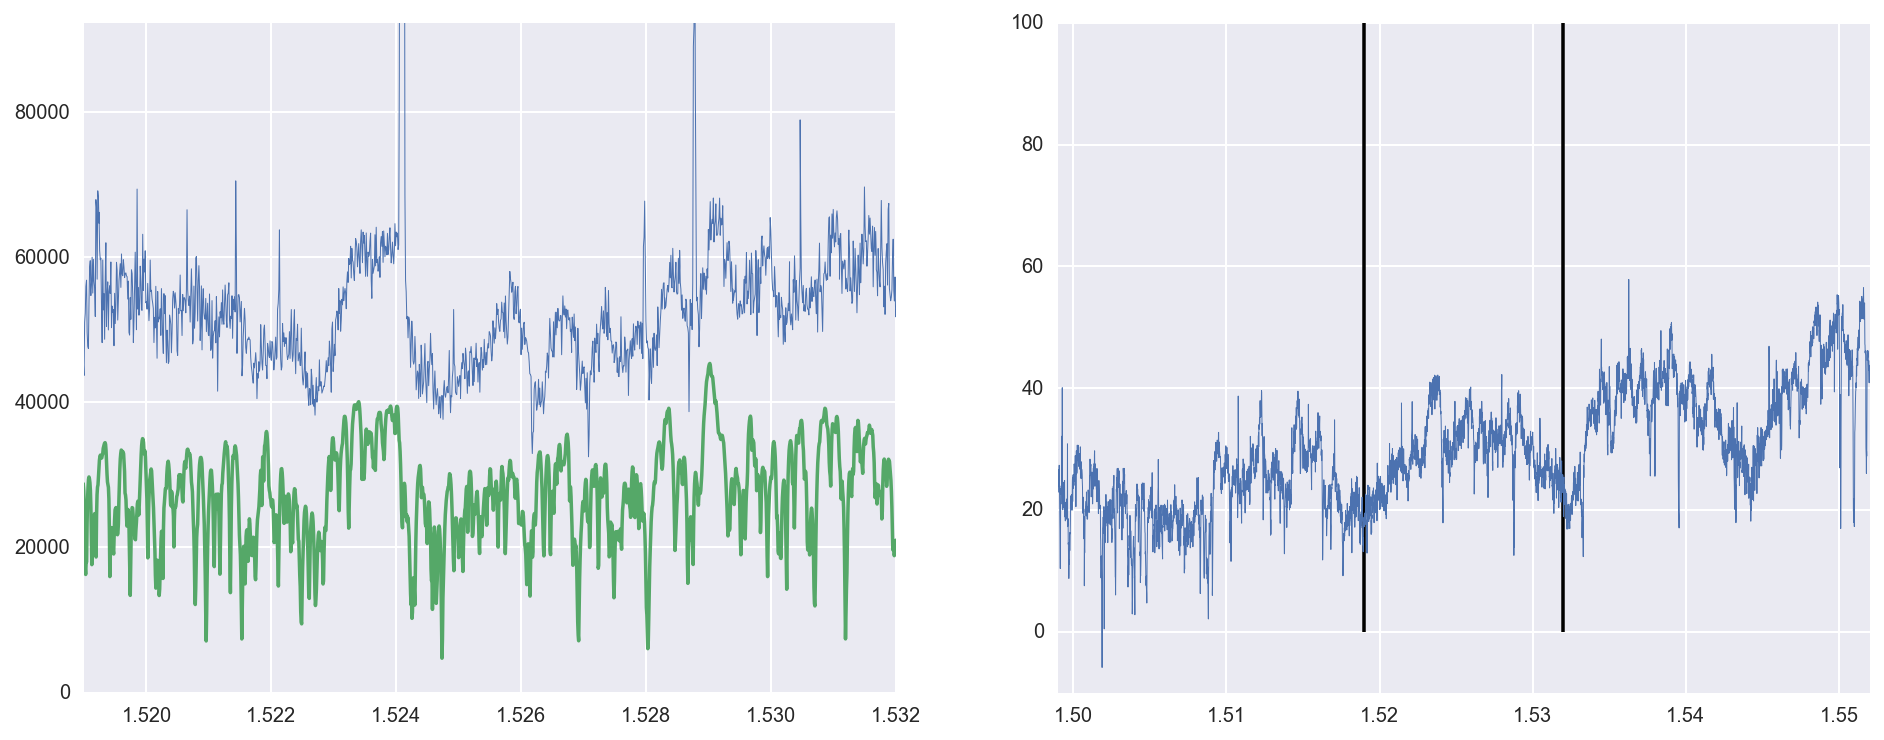

In [14]:
x1, x2 = 1.519, 1.532
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(dat.wl, dat.fl, lw=0.5)
plt.plot(x, y*3)
plt.ylim(0, 1.3*yl2)
plt.xlim(x1, x2)
plt.subplot(122)
plt.plot(dat.wl, dat.fl/dat.sigma, lw=0.5)
plt.vlines(x1, 0, 100)
plt.vlines(x2, 0, 100)
plt.ylim(-10, 100)
plt.xlim(x1-0.02, x2+0.02)

OK, let's pick a few demo orders:

- **m104:**   `x1, x2 = 1.716, 1.731`
- **m108:**   `x1, x2 = 1.655, 1.669`
- **m113:**   `x1, x2 = 1.585, 1.595`
- **m118:**   `x1, x2 = 1.519, 1.532`

## Save to HDF5 for Starfish

Clean the data and put into a form for Starfish ingestion

In [15]:
import h5py

### m = 118

In [16]:
gi = (dat.wl> 1.519) & (dat.wl < 1.532)
wlgrid = dat.wl[gi].values
Flux = dat.fl[gi].values
Flux_err = np.abs(dat.sigma[gi].values)

Let's manually clean the bad pixels.

(0, 100000)

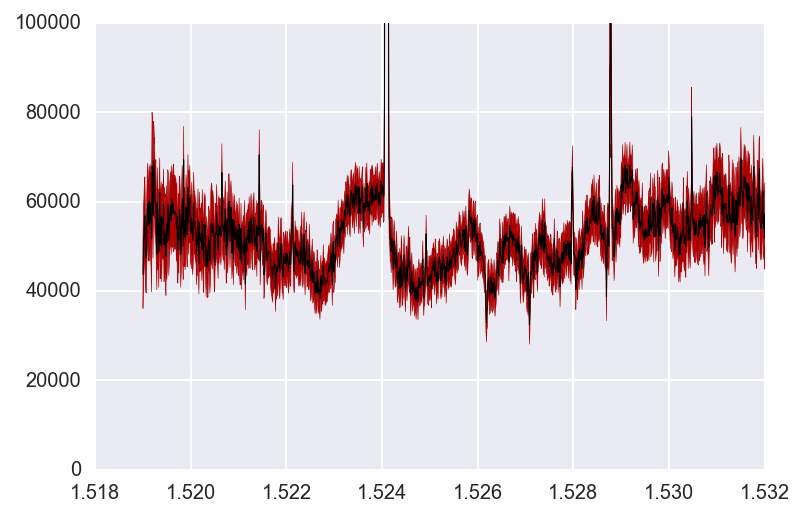

In [17]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err, Flux+3.0*Flux_err, color='#AA0000')
plt.ylim(0,100000)

In [18]:
bi = (Flux > 76000) | (Flux_err == 0)
Flux_err_alt = Flux_err
Flux_err_alt[bi] = Flux[bi]

(0, 100000)

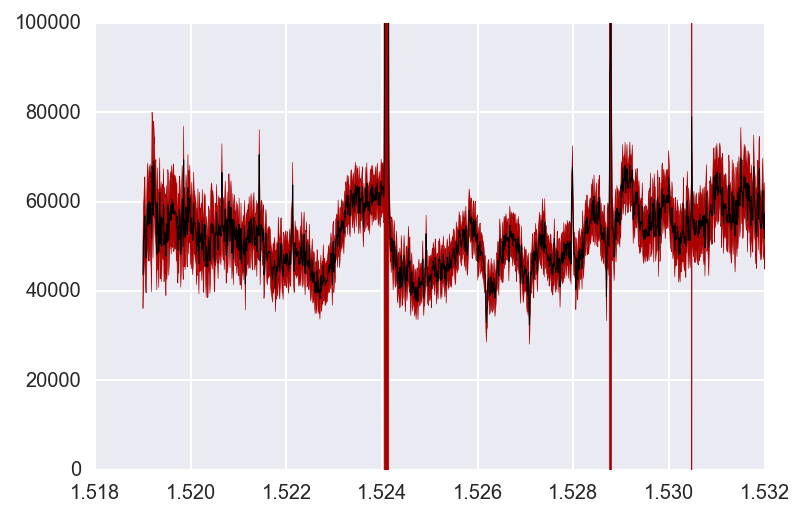

In [19]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err_alt, Flux+3.0*Flux_err_alt, color='#AA0000')
plt.ylim(0,100000)

Much better.

In [20]:
out_name = '../data/IGRINS/reduced/2M0136+0933_m118.hdf5'
fls_out = Flux
sig_out = Flux_err_alt
wls_out = wlgrid*10000.0
msk_out = np.ones(len(wls_out), dtype=int)
f_new = h5py.File(out_name, 'w')
f_new.create_dataset('fls', data=fls_out)
f_new.create_dataset('wls', data=wls_out)
f_new.create_dataset('sigmas', data=sig_out)
f_new.create_dataset('masks', data=msk_out)
print("{:.0f}  -  {:.0f}   {}".format(wls_out[0], wls_out[-1], out_name))
f_new.close()

15190  -  15320   ../data/IGRINS/reduced/2M0136+0933_m118.hdf5


### m = 113:  $\lambda = [1.585 - 1.595]$

In [21]:
gi = (dat.wl> 1.585) & (dat.wl < 1.595)
wlgrid = dat.wl[gi].values
Flux = dat.fl[gi].values
Flux_err = np.abs(dat.sigma[gi].values)

(60000, 100000)

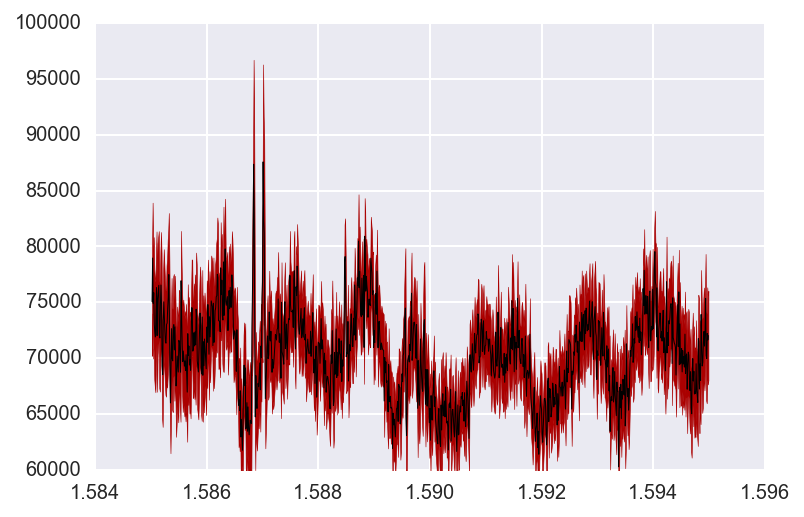

In [22]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err, Flux+3.0*Flux_err, color='#AA0000')
plt.ylim(60000,100000)

In [23]:
bi = (Flux > 85000) | (Flux_err == 0)
Flux_err_alt = Flux_err
Flux_err_alt[bi] = 0.3*Flux[bi]

(0, 100000)

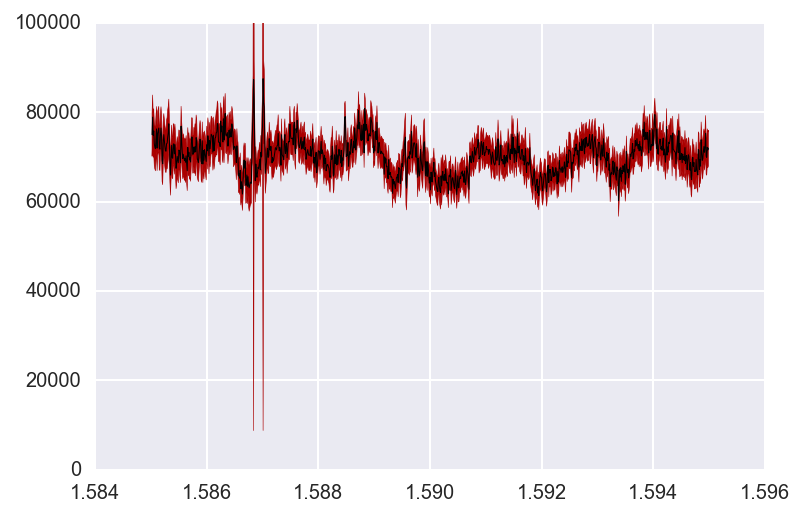

In [24]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err_alt, Flux+3.0*Flux_err_alt, color='#AA0000')
plt.ylim(0,100000)

Much better.

In [25]:
out_name = '../data/IGRINS/reduced/2M0136+0933_m113.hdf5'
fls_out = Flux
sig_out = Flux_err_alt
wls_out = wlgrid*10000.0
msk_out = np.ones(len(wls_out), dtype=int)
f_new = h5py.File(out_name, 'w')
f_new.create_dataset('fls', data=fls_out)
f_new.create_dataset('wls', data=wls_out)
f_new.create_dataset('sigmas', data=sig_out)
f_new.create_dataset('masks', data=msk_out)
print("{:.0f}  -  {:.0f}   {}".format(wls_out[0], wls_out[-1], out_name))
f_new.close()

15850  -  15950   ../data/IGRINS/reduced/2M0136+0933_m113.hdf5


### m = 108 $\lambda= [1.655, 1.669]$

In [26]:
gi = (dat.wl> 1.655) & (dat.wl < 1.669)
wlgrid = dat.wl[gi].values
Flux = dat.fl[gi].values
Flux_err = np.abs(dat.sigma[gi].values)

Let's manually clean the bad pixels.

(38000, 100000)

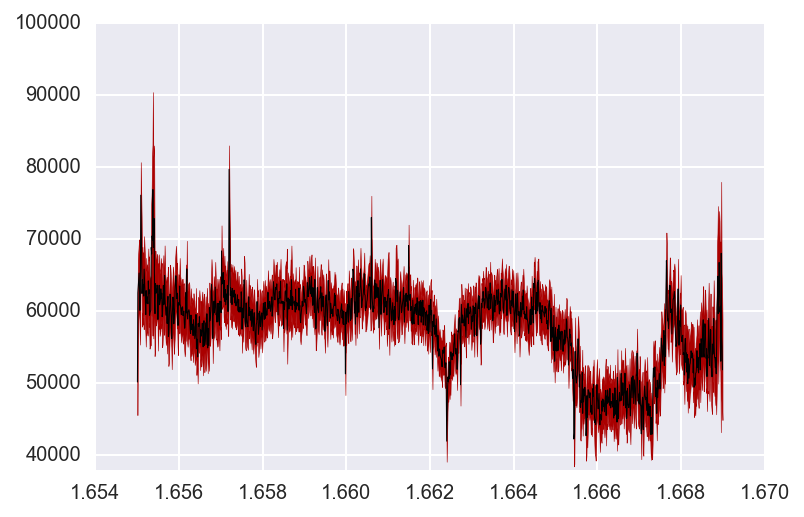

In [27]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err, Flux+3.0*Flux_err, color='#AA0000')
plt.ylim(38000,100000)

In [28]:
bi = (Flux > 75000) | (Flux_err == 0)
Flux_err_alt = Flux_err
Flux_err_alt[bi] = 0.3*Flux[bi]

(0, 100000)

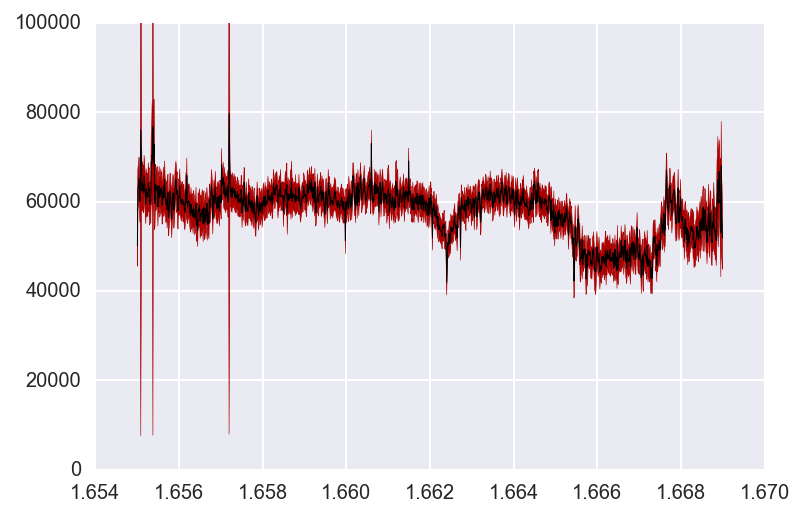

In [29]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err_alt, Flux+3.0*Flux_err_alt, color='#AA0000')
plt.ylim(0,100000)

Much better.

In [30]:
out_name = '../data/IGRINS/reduced/2M0136+0933_m108.hdf5'
fls_out = Flux
sig_out = Flux_err_alt
wls_out = wlgrid*10000.0
msk_out = np.ones(len(wls_out), dtype=int)
f_new = h5py.File(out_name, 'w')
f_new.create_dataset('fls', data=fls_out)
f_new.create_dataset('wls', data=wls_out)
f_new.create_dataset('sigmas', data=sig_out)
f_new.create_dataset('masks', data=msk_out)
print("{:.0f}  -  {:.0f}   {}".format(wls_out[0], wls_out[-1], out_name))
f_new.close()

16550  -  16690   ../data/IGRINS/reduced/2M0136+0933_m108.hdf5


### m = 104 $\lambda= [1.716, 1.731]$

In [31]:
gi = (dat.wl> 1.716) & (dat.wl < 1.731)
wlgrid = dat.wl[gi].values
Flux = dat.fl[gi].values
Flux_err = np.abs(dat.sigma[gi].values)

Let's manually clean the bad pixels.

(20000, 70000)

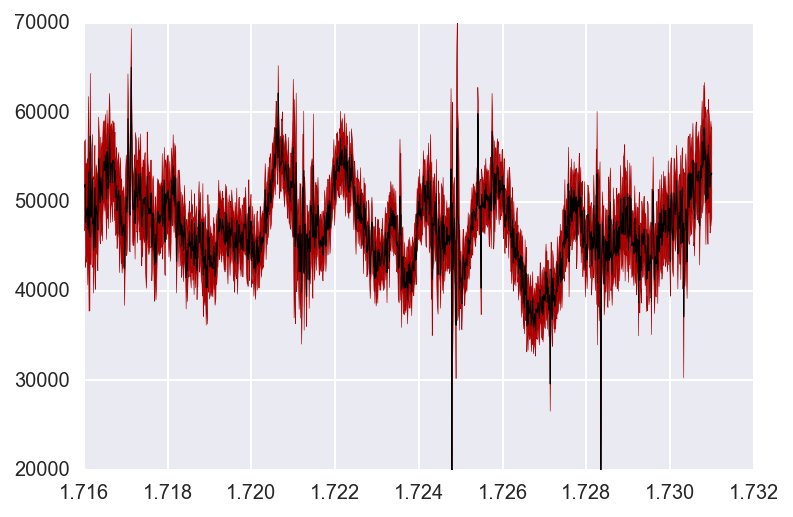

In [32]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err, Flux+3.0*Flux_err, color='#AA0000')
plt.ylim(20000,70000)

In [33]:
bi = (Flux > 62000) | (Flux_err == 0) | (Flux < 30000)
Flux_err_alt = Flux_err
Flux_err_alt[bi] = 0.3*Flux[bi]

(0, 100000)

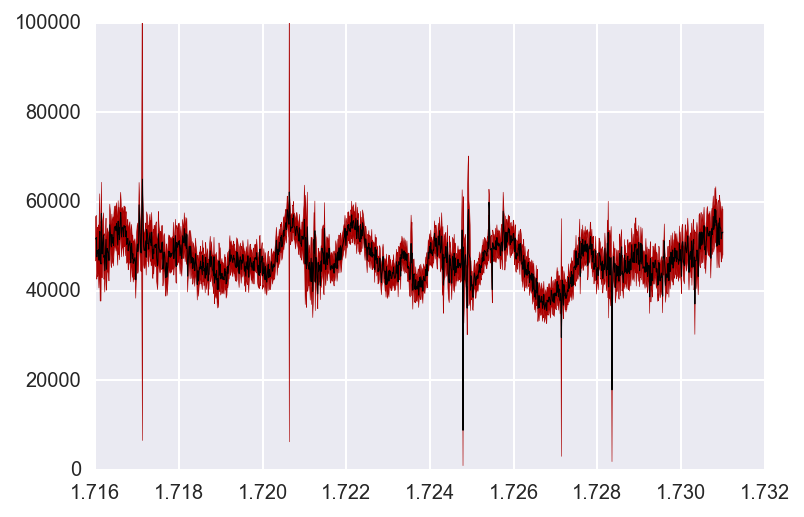

In [34]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err_alt, Flux+3.0*Flux_err_alt, color='#AA0000')
plt.ylim(0,100000)

Much better.

In [35]:
out_name = '../data/IGRINS/reduced/2M0136+0933_m104.hdf5'
fls_out = Flux
sig_out = Flux_err_alt
wls_out = wlgrid*10000.0
msk_out = np.ones(len(wls_out), dtype=int)
f_new = h5py.File(out_name, 'w')
f_new.create_dataset('fls', data=fls_out)
f_new.create_dataset('wls', data=wls_out)
f_new.create_dataset('sigmas', data=sig_out)
f_new.create_dataset('masks', data=msk_out)
print("{:.0f}  -  {:.0f}   {}".format(wls_out[0], wls_out[-1], out_name))
f_new.close()

17160  -  17310   ../data/IGRINS/reduced/2M0136+0933_m104.hdf5


## THE END.